# Simple CNN for LULC of Aerial Data
###### *Connor Crowe*

**Objective**: This notebook trains a **Convolutional Neural Network (CNN)** to classify land use and land cover (LULC) from aerial imagery. The goal is to be a first CNN to build off of to predict a segmentation mask that accurately identifies different land cover types in Toronto, Canada.

🔗 View previous models: [Repository](https://github.com/connorcrowe/to-lulc-aiml)

**Dataset**: 
- **Aerial Imagery**: training and prediction aerial clipped from [Toronto Aerial Imagery GIS Map Server (2019)](https://gis.toronto.ca/arcgis/rest/services/basemap/cot_ortho/MapServer)
    - Training image size: 512px
- **Labelled Rasters**: rasters manually digitized from the aerial imagery above
    - Classes: road, building, vegetation, pavement
  
**Workflow**:
- Data Preprocessing - Image patching, data augmentation
- Model: Compiling, fiting 
- Prediction: Generates segmentation mask on new data 

In [4]:
# IMPORTS AND RANDOM SEEDS
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from patchify import unpatchify
from patchify import patchify

RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

### Configuration
Variables that affect execution parameters and other optional settings.

In [9]:
# Patch Settings
patch_size = 128      # Size to split each training image into
patch_step = 32       # Amount to step when splitting up images for training (<size means some overlap)

# Training Settings
percent_augment = 1   # Amount of the training data set to randomly augment (brightness, orientation)
epochs = 150          # Epochs of training for the CNN (early stopping is enabled)

# Extra output settings
optional_visuals = 1

## Data Import
Import matching aerial image and labelled raster. Also import the larger image to be predicted once the model is trained.

In [6]:
full_image_path = "input/aerial.tif"                 # Aerial raster of entire area to be classified
labels_aerial_path = "input/labels_aerial_512.tif"   # Aerial raster of just labelled data
labels_classes_path = "input/labels_classes_512.tif" # Class raster of labelled data

In [7]:
# Load Full Image Aerial
with rasterio.open(full_image_path) as src:
    full_image_raw = src.read()  # Read all bands
    metadata = src.profile

# Load Classes Raster of Labelled Sample
with rasterio.open(labels_classes_path) as src:
    labels_classes_raw = src.read(1)  # Read the first (or only) band
    labels_classes_meta = src.profile

# Load Aerial Raster of Labelled Sample
with rasterio.open(labels_aerial_path) as src:
    labels_aerial_raw = src.read()
    labels_aerial_meta = src.profile

# Normalize images
full_image = full_image_raw.astype(np.float32) / 255.0  # Normalize to 0-1 range
labels_aerial = labels_aerial_raw.astype(np.float32) / 255.0 

# Print shapes
print("Full Image shape:", full_image.shape)  # Should be (Bands, Height, Width)
print("Labels Aerial shape:", labels_aerial.shape)
print("Labels Classes shape:", labels_classes_raw.shape)  # Should be (Height, Width)

Full Image shape: (3, 2347, 2560)
Labels Aerial shape: (3, 512, 512)
Labels Classes shape: (512, 512)


#### ***Optional:*** *Visualize full aerial and labelled data*

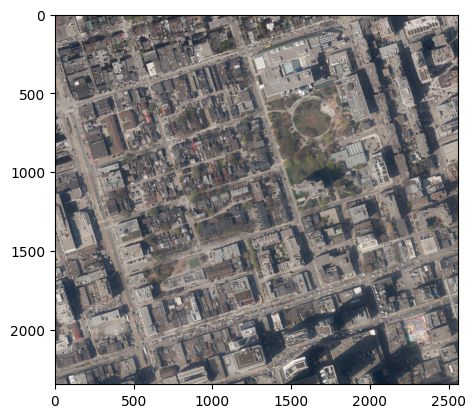

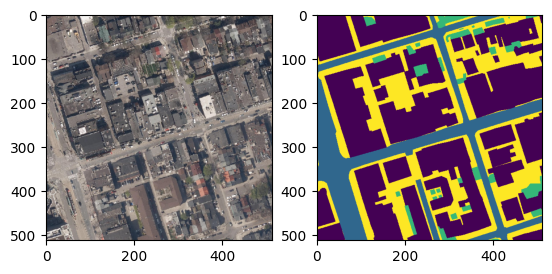

In [10]:
if optional_visuals:
    # Visualize full image
    rasterio.plot.show(full_image)

    # Visualize lablled aerial and classes
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(reshape_as_image(labels_aerial))
    ax[1].imshow(labels_classes_raw)

## Data Preparation
Before training, data is prepared by:
- **One Hot Encoding**: Convert numerical class to categorical columns
- **Train test split**: Split off parts of input image for training before patching (to prevent data leakage in overlap)
- **Patching**: Splitting the input image into smaller patches
- **Overlapping Patches**: An overlap between patches prevents segmentation artifacts at patch boundaries
- **Data Augmentation**: Random rotations, flips, brightess, saturation, hue and noise to improve generalization.

### Convert Class Labels to Categorical (One-Hot Encoded)

In [7]:
# SHIFT LABELS
# Classes are 1-indexed, need them 0-indexed                   # 0 building, 1 road, 2 vegetation, 3 alley/sidewalk/pavement
labels_classes_shifted = labels_classes_raw - 1

# ENCODE LABLES
num_classes = len(np.unique(labels_classes_shifted))
labels_classes = to_categorical(labels_classes_shifted, num_classes=num_classes)

print(f"Encoded {num_classes} classes") 

Encoded 4 classes


### Split Training and Testing Data

In [8]:
# TRAIN TEST SPLIT
split_x = int(labels_classes.shape[1] * 0.75) 

# Crop aerial and labels into train and test regions
labels_classes_train = labels_classes[:, :split_x]  
labels_classes_test = labels_classes[:, split_x:]  

labels_aerial_train = labels_aerial[:, :, :split_x]  
labels_aerial_test = labels_aerial[:, :, split_x:] 

print(type(labels_classes_raw))
print(f"labels_aerial_train: {labels_aerial_train.shape}, labels_classes_train: {labels_classes_train.shape}")
print(f"labels_aerial_test: {labels_aerial_test.shape},  labels_classes_test: {labels_classes_test.shape}")

<class 'numpy.ndarray'>
labels_aerial_train: (3, 512, 384), labels_classes_train: (512, 384, 4)
labels_aerial_test: (3, 512, 128),  labels_classes_test: (512, 128, 4)


### Create Image Patches
The input image must be split into smaller samples before training the model, achieved using Patchify. By setting a patch step smaller than the patch size, the resulting patches overlap. This can help to expand the training set and give the model better spatial representation, especially on border regions between patches.

In [9]:
# CREATE OVERLAPPING PATCHES
# Patchify separately for train and test to prevent data leakage
patches_classes_train = patchify(labels_classes_train, (patch_size, patch_size, num_classes), step=patch_step)
patches_classes_test = patchify(labels_classes_test, (patch_size, patch_size, num_classes), step=patch_step)

patches_aerial_train = patchify(labels_aerial_train, (3, patch_size, patch_size), step=patch_step)[0]
patches_aerial_test = patchify(labels_aerial_test, (3, patch_size, patch_size), step=patch_step)[0]

# Reshape patches into lists
X_train_orig = patches_aerial_train.reshape(-1, 3, patch_size, patch_size)
X_train_orig = np.transpose(X_train_orig, (0, 2, 3, 1))


Y_train_orig = patches_classes_train.reshape(-1, patch_size, patch_size, num_classes)

X_test = patches_aerial_test.reshape(-1, 3, patch_size, patch_size)
X_test = np.transpose(X_test, (0, 2, 3, 1))

Y_test = patches_classes_test.reshape(-1, patch_size, patch_size, num_classes)

print(f"New Train set - X: {X_train_orig.shape}, Y: {Y_train_orig.shape}")
print(f"New Test set -  X: {X_test.shape},  Y: {Y_test.shape}")

New Train set - X: (117, 128, 128, 3), Y: (117, 128, 128, 4)
New Test set -  X: (13, 128, 128, 3),  Y: (13, 128, 128, 4)


#### ***Optional:*** *Visualize patches*

In [10]:
patches_to_show = 4 # How many patches to show (<20 recommended)

if optional_visuals:    
    shown = 0
    num_patches = X_train.shape[0]

    # Visulaize aerial raster and class raster patches next to each other
    while shown < min(patches_to_show, num_patches):    
        fig, ax = plt.subplots(1, 2, figsize=(10,10))
        ax[0].imshow(X_train[shown])
        ax[1].imshow(Y_train[shown])

        shown += 1

### Data Augmentation
Neural networks can enhance performance by useing augmented training data.

The **augments** applied are:
- Modified brightness, contrast, saturation and hue
- Random horizontal flip, random rotate, random zoom
- Adding random guassian noise

In [11]:
def augment(image, label, brightness_factor=0.2, flip_prob=0.5, rotate_prob=0.5, noise_prob=0.5, zoom_prob=0.2):
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=brightness_factor)

    # Random contrast
    image  = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Random hue
    image = tf.image.random_hue(image, max_delta=0.05)
    
    # Random horizontal flipping
    if tf.random.uniform([]) < flip_prob:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    # Random rotation (90, 180, 270)
    if tf.random.uniform([]) < rotate_prob:
        k = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        label = tf.image.rot90(label, k=k)

    # Gaussian noise
    if tf.random.uniform([]) < noise_prob:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # Random zoon
    if tf.random.uniform([]) < zoom_prob:
        crop_factor = tf.random.uniform([], minval=0.7, maxval=1.0)
        h, w, _ = image.shape
        new_h = tf.cast(h * crop_factor, tf.int32)
        new_w = tf.cast(w * crop_factor, tf.int32)

        image = tf.image.resize_with_crop_or_pad(image, new_h, new_w)
        label = tf.image.resize_with_crop_or_pad(label, new_h, new_w)

        image = tf.image.resize(image, [h,w])
        label = tf.image.resize(label, [h,w])

    return image, label

In [12]:
# Randomly select indices for augmentation
num_aug_samples = int(percent_augment * X_train_orig.shape[0])
augment_indices = np.random.choice(X_train_orig.shape[0], num_aug_samples, replace=False)

# Apply augmentation
X_aug = []
Y_aug = []

for idx in augment_indices:
    new_image, new_label = augment(X_train_orig[idx], Y_train_orig[idx])
    X_aug.append(np.array(new_image))  
    Y_aug.append(np.array(new_label))
    
# Convert to NumPy and concatenate with original dataset
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

X_train = np.concatenate([X_train_orig, X_aug], axis=0)
Y_train = np.concatenate([Y_train_orig, Y_aug], axis=0)

print(f"Added {num_aug_samples} augmented images. New training total: {X_train.shape[0]}")

Added 117 augmented images. New training total: 234


## Build CNN Model
Straight forward encoder followed by upsampling to try to work out simple spatial features. 

In [13]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(patch_size, patch_size,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),  # Upsample back

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(4, (1,1), activation='softmax')  # Output 4 classes per pixel
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
#model.summary()

C:\Users\Connor\Documents\Code\QGIS\to-lulc-aiml\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Fit the Model

In [14]:
# Enable early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test),
                    epochs=epochs, batch_size=10, 
                    callbacks=[early_stopping],
                   )

Epoch 1/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.4520 - loss: 1.2752 - val_accuracy: 0.5619 - val_loss: 1.0834
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.5328 - loss: 1.0912 - val_accuracy: 0.5619 - val_loss: 1.0661
Epoch 3/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5328 - loss: 1.0993 - val_accuracy: 0.5619 - val_loss: 1.0559
Epoch 4/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5328 - loss: 1.0651 - val_accuracy: 0.5619 - val_loss: 1.0388
Epoch 5/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5328 - loss: 1.0466 - val_accuracy: 0.5619 - val_loss: 1.0106
Epoch 6/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5371 - loss: 1.0035 - val_accuracy: 0.5659 - val_loss: 0.9499
Epoch 7/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5692 - loss: 0.9790 - val_accuracy: 0.5814 - val_loss: 0.9133
Epoch 8/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.6009 - loss: 0.9071 - val_accuracy

### Evaluate Accuracy

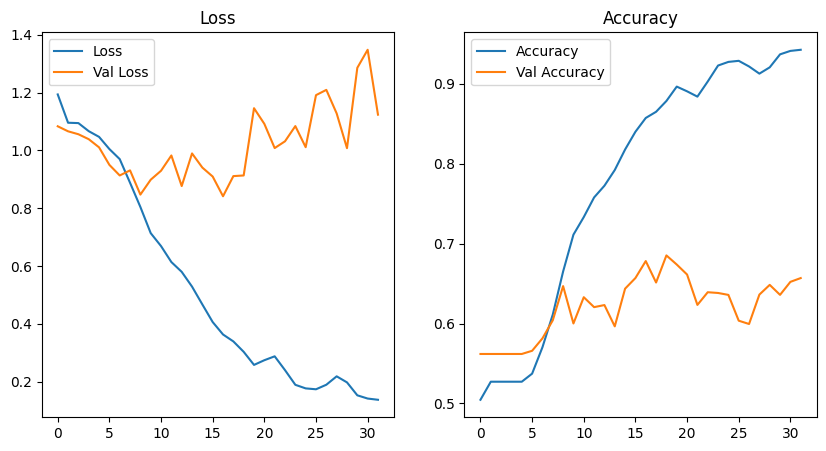

In [15]:
# Plot training loss & accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()

## Predict the Image
With the model trained it can now be used to predict land use classes for a new aerial image. The image will be split into patches of the same size as the training patches, but can be set to have a different step for more or less overlap. 

### Full Image Preprocessing

In [16]:
full_image_reshaped = reshape_as_image(full_image)
print("Full Image shape:", full_image_reshaped.shape)  

# Turn full image into patches to be predicted (same size and step as before)
patches_full = patchify(full_image_reshaped, (patch_size, patch_size, 3), step=patch_step)
patches_full_x, patches_full_y = patches_full.shape[0:2]

# Turn 2D array of patches into one list of patches i.e. (num_patches, patch_size, patch_size, bands)
patches_full_reshaped = patches_full.reshape(-1, patch_size, patch_size, 3)
print("Reshaped for Model shape:", patches_full_reshaped.shape)  

Full Image shape: (2347, 2560, 3)
Reshaped for Model shape: (5390, 128, 128, 3)


### Full Image Prediction

In [17]:
# Predict the full image
predictions = model.predict(patches_full_reshaped)
print("Predictions shape:", predictions.shape) 

predictions = predictions.reshape(patches_full.shape[0], patches_full.shape[1], patch_size, patch_size, -1)

predicted_classes = np.argmax(predictions, axis=-1)

169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step
Predictions shape: (5390, 128, 128, 4)


#### Reassemble the Image from Predicted Patches
Put the prediction patches into one image. To deal with the overlap, and average blend is taken. A guassian blend was attempted but created worse results given the square grid nature of the roadway network being predicted in Toronto.

(2368, 2592)


C:\Users\Connor\AppData\Local\Temp\ipykernel_28288\1707949095.py:20: RuntimeWarning: invalid value encountered in divide
  full_prediction /= weight_matrix
C:\Users\Connor\AppData\Local\Temp\ipykernel_28288\1707949095.py:21: RuntimeWarning: invalid value encountered in cast
  full_prediction = full_prediction.astype(np.uint8)


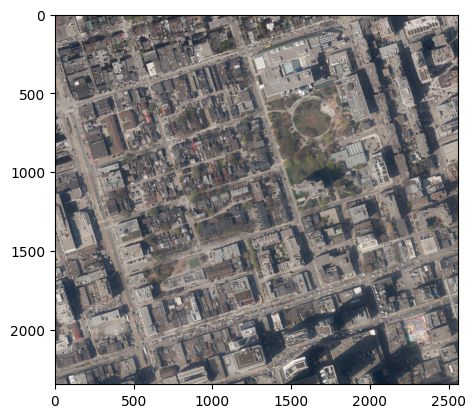

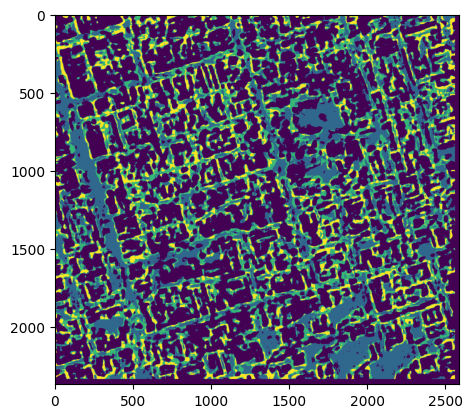

Average weighted blending
Training size: (512, 512)
Prediction size: (2368, 2592)
Patch size: 128
Patch step: 32
Augmented: 100%


In [18]:
## AVERAGE BLENDING IMPLEMENTATION
# Initialize accumulation and weight matrices
full_prediction = np.zeros((patches_full_x * patch_step + patch_size, 
                            patches_full_y * patch_step + patch_size), dtype=np.float32)
weight_matrix = np.zeros_like(full_prediction, dtype=np.float32)
print(full_prediction.shape)

# Blend patches
for i in range(patches_full_x):
    for j in range(patches_full_y):
        x_start = i * patch_step
        x_end = x_start + patch_size
        y_start = j * patch_step
        y_end = y_start + patch_size
        
        full_prediction[x_start:x_end, y_start:y_end] += predicted_classes[i, j]
        weight_matrix[x_start:x_end, y_start:y_end] += 1  # Track contributions

# Normalize by the number of times each pixel was predicted
full_prediction /= weight_matrix
full_prediction = full_prediction.astype(np.uint8)

# Patch results and display
rasterio.plot.show(full_image)
rasterio.plot.show(full_prediction)

print(f"Average weighted blending\nTraining size: {labels_classes_raw.shape}\nPrediction size: {full_prediction.shape}\nPatch size: {patch_size}\nPatch step: {patch_step}\nAugmented: {percent_augment*100}%")

In [19]:
# Rescale predictions for visualization/export
scaled_prediction = full_prediction.astype(np.float32) * (255.0 / 3.0)
scaled_prediction = np.clip(scaled_prediction, 0, 255).astype(np.uint8)

# Use original metadata
metadata.update({
    "dtype": "uint8",  # Match predicted dtype
    "count": 1,        # Single band output
})

# Save the prediction as a GeoTIFF
output_path = f"result/{full_image.shape[1]}out_res_{patch_size}patch_{patch_step}step_{patch_step}pred_step.tif"
with rasterio.open(output_path, "w", **metadata) as dst:
    dst.write(scaled_prediction, 1)
print(f"Prediction saved to {output_path}")


Prediction saved to result/2347out_res_128patch_32step_32pred_step.tif


## Appendix: Unused Gaussian Weighted Blending of Overlapping Patch Regions
Found to be less reliable that average weighting for typical input.

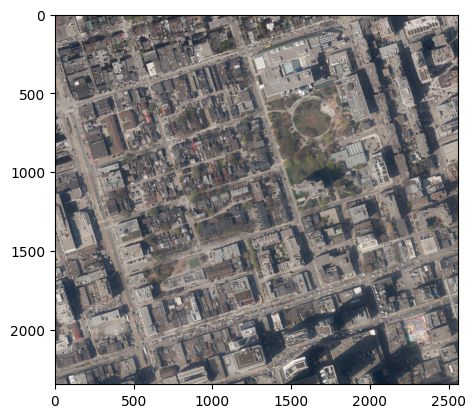

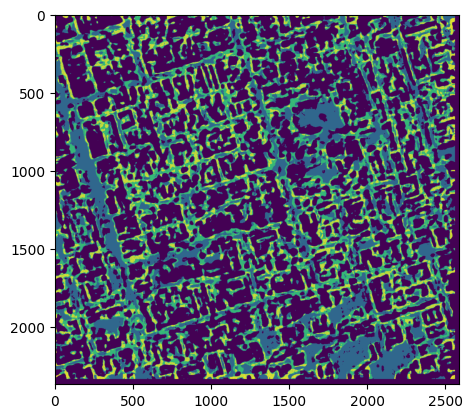

Gaussian weighted blending
Training size: (512, 512)
Prediction size: (2368, 2592)
Patch size: 128
Patch step: 32
Augmented: 100%


In [20]:
## GAUSSIAN WEIGHTED IMPLEMENTATION
# Create a Gaussian weight matrix for blending
def gaussian_weight_matrix(size, sigma=0.5):
    """Creates a Gaussian weight matrix for blending patches."""
    center = size // 2
    x = np.arange(size)
    y = np.arange(size)
    xx, yy = np.meshgrid(x - center, y - center)
    gaussian = np.exp(-(xx**2 + yy**2) / (2 * (sigma * size) ** 2))
    return gaussian / np.max(gaussian)  # Normalize to 1

# Generate Gaussian weight matrix for blending
gaussian_weights = gaussian_weight_matrix(patch_size)

# Initialize accumulation and weight matrices
full_prediction = np.zeros((patches_full_x * patch_step + patch_size, 
                            patches_full_y * patch_step + patch_size), dtype=np.float32)
weight_matrix = np.zeros_like(full_prediction, dtype=np.float32)

# Blend patches with Gaussian weighting
for i in range(patches_full_x):
    for j in range(patches_full_y):
        x_start = i * patch_step
        x_end = x_start + patch_size
        y_start = j * patch_step
        y_end = y_start + patch_size

        full_prediction[x_start:x_end, y_start:y_end] += predicted_classes[i, j] * gaussian_weights
        weight_matrix[x_start:x_end, y_start:y_end] += gaussian_weights  # Track weighted contributions

# Normalize by the weighted sum to avoid intensity distortion
full_prediction /= (weight_matrix + 1e-8)  # Avoid division by zero
full_prediction = full_prediction.astype(np.uint8)

# Patch results and display
rasterio.plot.show(full_image)
rasterio.plot.show(full_prediction)

print(f"Gaussian weighted blending\nTraining size: {labels_classes_raw.shape}\nPrediction size: {full_prediction.shape}\nPatch size: {patch_size}\nPatch step: {patch_step}\nAugmented: {percent_augment*100}%")